In [1]:
%load_ext autoreload
%autoreload 2


In [29]:
from config import *
from functions import *
from sim import *
from read_ramses import *
from scipy.interpolate import interp1d
import const


### feedback model

In [13]:
dx = 10 * const.pc
n_H = 100
metallicity = const.Z_sol

def fbk_ramses(n_H, metallicity, dx):

    r_cool = 3 * const.pc * (metallicity / const.Z_sol)**(-0.082) * (n_H / 100)**(-0.42)
    mom_SN = 1.42e5 * const.km * const.M_sol * (metallicity / const.Z_sol)**(-0.137) * (n_H / 100)**(-0.16)
    mom = mom_SN * np.minimum(1, (dx / r_cool)**(3/2)) * (r_cool < 4 * dx)
    return mom

def fbk_martizzi(n_H, metallicity, dx):
    
    alpha = -11 * (metallicity / const.Z_sol)**(0.07) * (n_H / 100)**(0.114)
    r_cool = 6.3 * const.pc * (metallicity / const.Z_sol)**(-0.05) * (n_H / 100)**(-0.42)
    r_thm = 9.2 * const.pc * (metallicity / const.Z_sol)**(-0.067) * (n_H / 100)**(-0.44)
    r0 = 2.4 * const.pc * (metallicity / const.Z_sol)**(0.021) * (n_H / 100)**(-0.35)
    r_mom = 8 * const.pc * (metallicity / const.Z_sol)**(-0.058) * (n_H / 100)**(-0.46)
    
    energy_SN = 1e51
    mom_SN = 1.42e5 * const.km * const.M_sol
    
    energy = energy_SN * ((r_cool - dx) + (dx / r_cool)**alpha * (dx > r_cool) * (r_thm > dx) + (r_thm / r_cool)**alpha * (r > r_thm))
    mom = mom_SN * ((dx / r0)**1.5 * (r_mom > dx) + (r_mom / r0) * (dx > r_mom))
    
    return energy, mom


### massive star mass fraction

In [112]:
def kroupa(m):
    imf = np.zeros_like(m)
    imf[m < 0.08] = 25 * m[m < 0.08]**(-0.3)
    imf[(m > 0.08) * (m < 0.5)] = 2 * m[(m > 0.08) * (m < 0.5)]**(-1.3)
    imf[(m > 0.5) * (m < 1.0)] = m[(m > 0.5) * (m < 1.0)]**(-2.3)
    imf[m > 1.0] = m[m > 1.0]**(-3.7)
    return imf

m = np.logspace(-2, 1)
imf = kroupa(m)

np.sum()


In [113]:
m_SNe = 8 # mass above which Type II SNe occur

kroupa_norm = 25 / (-0.3 + 2) * 0.08**(-0.3 + 2) \
    + 2 / (-1.3 + 2) * (0.5**(-1.3 + 2) - 0.08**(-1.3 + 2)) \
    + 1 / (-2.3 + 2) * (1.0**(-2.3 + 2) - 0.5**(-2.3 + 2)) \
    + -1 / (-2.7 + 2) * 1.0**(-2.7 + 2) # integral of the Kroupa IMF
kroupa_SNe = -1 / (-2.7 + 2) * m_SNe**(-2.7 + 2) # integral of the Kroupa IMF above m_SNe
eps_SNe = kroupa_SNe / kroupa_norm # mass fraction of stars that go SNe

eps_SNe


0.0907728971746926

### timescales

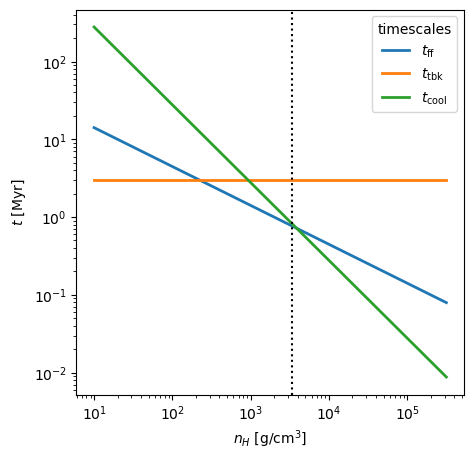

In [14]:
num = 100
metallicity = 1.0 * const.Z_sol
temp = 10**4
C = 1

M_cl = 10**6 * const.M_sol
V_w = 10**3.5 * const.km
R_gal = 1 * const.kpc
M_gen = 10**9 * const.M_sol

n_H = np.logspace(1, 5.5, num) # Hydrogen number density
rho = n_H * const.m_H / const.X_cosmo
t_ff = np.sqrt(3 * np.pi / (32 * const.G * rho))
t_fbk = np.full_like(rho, 3 * const.Myr)
t_cool = 0.87 * const.Myr * (n_H / 10**3.5)**(-1) * (metallicity / const.Z_sol)**(-1) * (temp / 10**4) * np.exp(0.009 * (temp / 10**4)**(-1)) * C**(-1)
t_sh = 5 * const.Myr * (n_H / 10**3.5)**(-1/6) * (M_cl / (10**6 * const.M_sol))**(1/3) * (V_w / (10**3.5 * const.km))**(-1/2) * (R_gal / const.kpc) * (M_gen / (10**9 * const.M_sol))**(-1/2)
n_cool = 3.4e3 * (metallicity / const.Z_sol)**(-2) * (temp / 10**4)**2 * C**(-2)

plt.figure(figsize=(5, 5))

plt.plot(n_H, t_ff / const.Myr, lw=2, label=r'$t_{\rm ff}$')
plt.plot(n_H, t_fbk / const.Myr, lw=2, label=r'$t_{\rm tbk}$')
plt.plot(n_H, t_cool / const.Myr, lw=2, label=r'$t_{\rm cool}$')
#plt.plot(n_H, t_sh / const.Myr, lw=2, label=r'$t_{\rm shield}$')
plt.axvline(x=n_cool, color='black', linestyle=':')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$n_H$ [${\rm g/cm^3}$]')
plt.ylabel(r'$t$ [${\rm Myr}$]')
plt.legend(title='timescales')


Saved figure as 'mstartemp-013120241236.png'


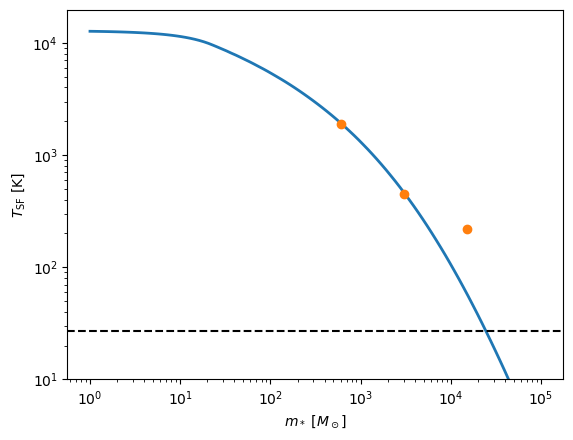

In [90]:
m_star = np.logspace(0, 5, 100) * const.M_sol
time_starform = 0.1*const.Myr
dt = 500*const.yr
rho_starform = 1e-20
energy_turb_starform = 1e13
dx = 10*const.pc

num_tstep = time_starform / dt
m_gas = -m_star * np.log(1 - 0.5) / num_tstep
t_ff_starform = np.sqrt(3 * np.pi / (32 * const.G * rho_starform))
eps_sf = m_gas / dx**3 / dt / rho_starform * t_ff_starform

temp = np.logspace(1, 4, 100)
eps_sf_interp = interp1d(calc_eps_sf2(rho_starform, energy_turb_starform, temp, dx), temp, fill_value='extrapolate')

plt.plot(m_star / const.M_sol, eps_sf_interp(eps_sf), lw=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$m_*$ [$M_\odot$]')
plt.ylabel(r'$T_{\rm SF}$ [${\rm K}$]')
plt.axhline(y=27, color='black', linestyle='--')

plt.plot([600, 3000, 15000], [1890, 446, 218], 'o')
plt.ylim(10)

save_fig('mstartemp')
